In [184]:
# Handle required imports
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, EfficientSU2
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from sklearn.svm import SVC

# Load the iris dataset from the package
from sklearn import datasets
iris = datasets.load_iris()

# EXPLORING QUANTUM MACHINE LEARNING
## QUAC605 FINAL PROJECT
### Prepared by: Tomomi Nakamura, Alexander Varga and Francisco Granda

## Part 1 - Neural Network Classifier

### Part 1.1 - Data Preparation
For this section, the Iris dataset is prepared by using the Setosa and Versicolour classes. Additionally, the the first and second features (Sepal Length and Sepal Width) will be used for training the models:

In [185]:
# Set the random seed
np.random.seed(42)

# Select only two classes (setosa, versicolor)
X_total = []
y01_total = []

for idx,target in enumerate(iris.target):
    if target < 2:
        X_total.append([iris.data[idx,0],iris.data[idx,1],target]) # Here we select first and second features

# Convert to np array
X_total = np.array(X_total)

# Shuffle rows in place
np.random.shuffle(X_total)

# Split the array into two halves
split_index = len(X_total) // 2
X_train = X_total[:split_index]
X_test = X_total[split_index:]

# Convert lists to numpy arrays
X = X_train[:, :2]
y01 = X_train[:, 2]
y01_test = X_test[:, 2]
X_test = X_test[:, :2]

# Convert to classes {-1,+1}
y = 2 * y01 - 1  # in {-1, +1}
y_test = 2 * y01_test - 1  # in {-1, +1}

The original dataset is separated into a training and testing individual datasets. The training dataset is presented as follows:

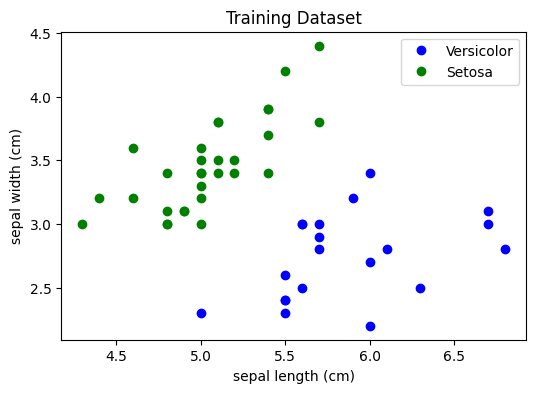

In [186]:
# Plot the samples
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")

# Add a legend for the two groups
plt.plot([], [], "bo", label="Versicolor")
plt.plot([], [], "go", label="Setosa")

# Label the axis and show
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Training Dataset")

plt.legend()
plt.show()

Similarly, the testing dataset can be presented as follows:

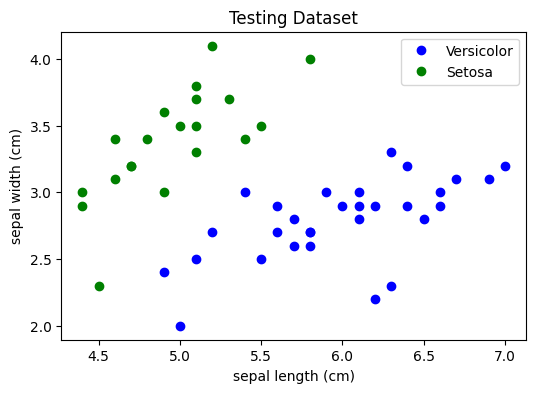

In [187]:
# Plot the samples
for x, y_target in zip(X_test, y_test):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")

# Add a legend for the two groups
plt.plot([], [], "bo", label="Versicolor")
plt.plot([], [], "go", label="Setosa")

# Label the axis and show
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Testing Dataset")
plt.legend()
plt.show()

### Part 1.2 - Preparing the Quantum Neural Network
For this, we define the number of inputs corresponding to two features and use Qiskit's QNNCircuit class to prepare the parametrized quantum circuit by using the RealAplitudes ansatz:

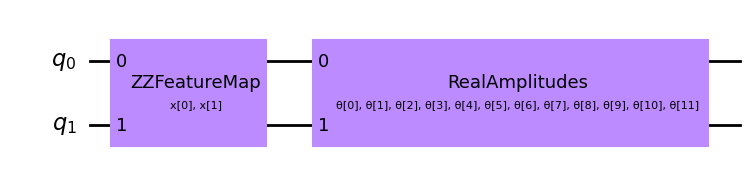

In [188]:
# Construct QNN with the QNNCircuit's default ZZFeatureMap feature map and RealAmplitudes ansatz.
num_inputs = 2
qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=5))
qc.draw("mpl", style="clifford")

Then we can proceed with the EstimatorQNN class with the previously defined quantum circuit:

In [189]:
# Create the estimator class with the quantum circuit
estimator_qnn = EstimatorQNN(circuit=qc)

/tmp/ipykernel_562889/848189972.py:2: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator_qnn = EstimatorQNN(circuit=qc)
/tmp/ipykernel_562889/848189972.py:2: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (2). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator_qnn = EstimatorQNN(circuit=qc)


### Part 1.3 - Training the Model

At this point, the NeuralNetworkClassifier can be implemented with the COBYLA classical optimizer for minimization. For this, a callback function is created for observing the evolution of the loss function. Then, the training dataset is used for fitting the model and the testing dataset is used to compute a classifier score:

205


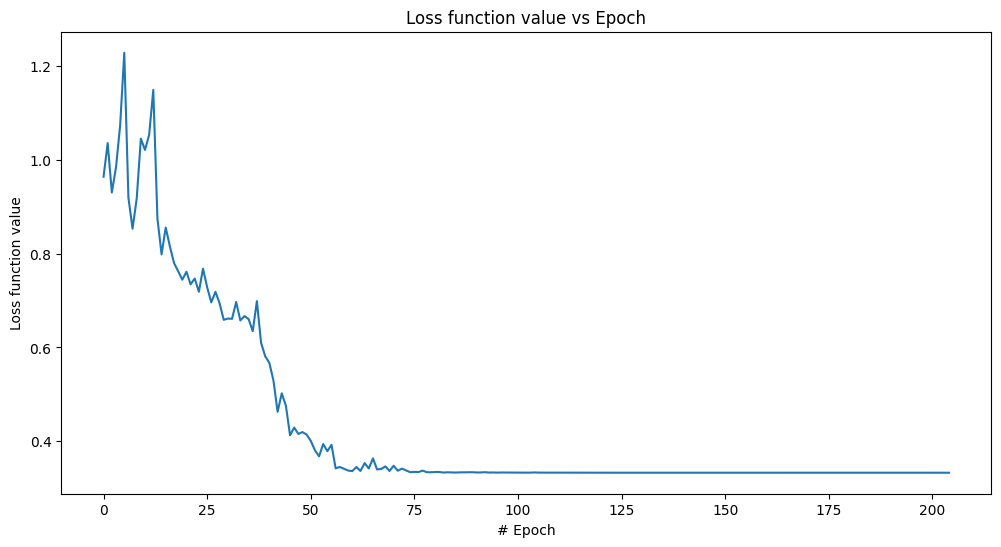

QNN Classifier Train Score:  0.94
QNN Classifier Test Score:  0.94


In [190]:
# Callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print(len(objective_func_vals))
    plt.title("Loss function value vs Epoch")
    plt.xlabel("# Epoch")
    plt.ylabel("Loss function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
# Construct the neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=600), callback=callback_graph
)

# Create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Fit classifier to data
estimator_classifier.fit(X, y)
plt.rcParams["figure.figsize"] = (6, 4)

# Retrieve the score for the classifier
qnn_train_score = estimator_classifier.score(X, y)
qnn_test_score = estimator_classifier.score(X_test, y_test)
print("QNN Classifier Train Score: ", qnn_test_score)
print("QNN Classifier Test Score: ", qnn_test_score)

### Part 1.3 - Testing the Model

With the implementation of the classifier finished, the "predict" method can be used to test the classifier and visualize the results:

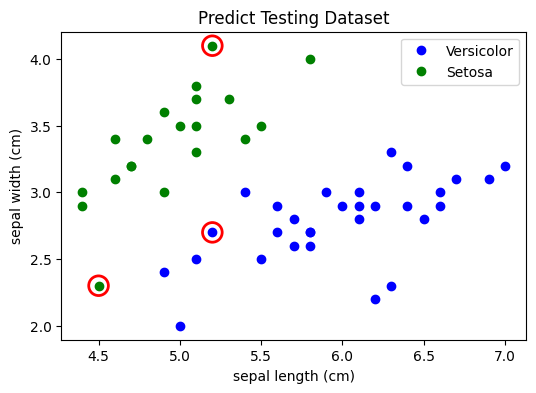

In [191]:
# evaluate data points
y_predict = estimator_classifier.predict(X_test)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, y_test, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)

# Add a legend for the two groups
plt.plot([], [], "bo", label="Versicolor")
plt.plot([], [], "go", label="Setosa")

# Label the axis
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Predict Testing Dataset")

plt.legend()
plt.show()

With a score of 0.94, the figure presents the samples where an incorrect classification occurred.

Here, it is important to consider that the selection of the Ansatz circuit is going to have an effect in the performance of the classifier. To observe this, the same implementation presented in sections 1.2 and 1.3 can be reimplemented with the EfficientSU2 Ansatz:

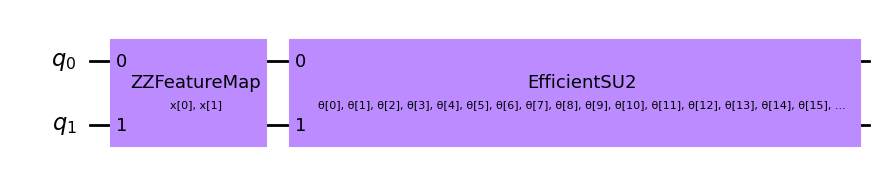

In [192]:
# Construct QNN with the QNNCircuit's default ZZFeatureMap feature map and EfficientSU2 ansatz.
num_inputs = 2
qc = QNNCircuit(ansatz=EfficientSU2(num_inputs, reps=5))
qc.draw("mpl", style="clifford")

481


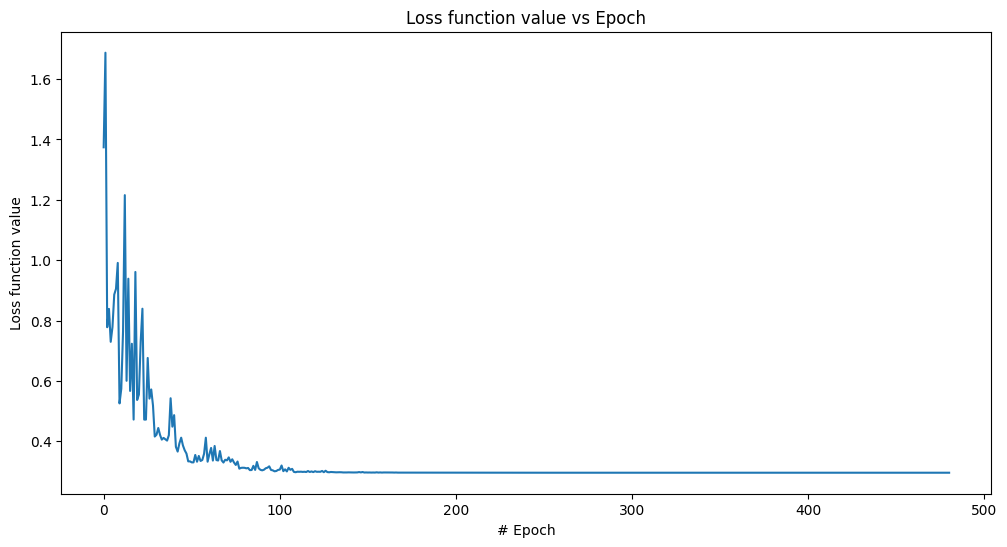

QNN Classifier Train Score:  0.96
QNN Classifier Test Score:  0.96


In [193]:
# Create the estimator class with the quantum circuit
estimator_qnn = EstimatorQNN(circuit=qc)
  
# Construct the neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=600), callback=callback_graph
)

# Create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Fit classifier to data
estimator_classifier.fit(X, y)
plt.rcParams["figure.figsize"] = (6, 4)

# Retrieve the score for the classifier
qnn_train_score = estimator_classifier.score(X, y)
qnn_test_score = estimator_classifier.score(X_test, y_test)
print("QNN Classifier Train Score: ", qnn_test_score)
print("QNN Classifier Test Score: ", qnn_test_score)

## Part 2 - Quantum Kernel Classifier

### Part 2.1 - Data Preparation
For this section, the Iris dataset is prepared in the same way than in section 1.1 by using the Setosa and Versicolour classes:

In [194]:
# Set dimension size based on input features
adhoc_dimension = 2
# Set the random seed
np.random.seed(42)

# Select only two classes (setosa, versicolor)
X_total = []
y01_total = []

for idx,target in enumerate(iris.target):
    if target < 2:
        X_total.append([iris.data[idx,0],iris.data[idx,1],target]) # Here we select first and second features

# Convert to np array
X_total = np.array(X_total)

# Shuffle rows in place
np.random.shuffle(X_total)

# Split the array into two halves
split_index = len(X_total) // 2
X_train = X_total[:split_index]
X_test = X_total[split_index:]

# Convert lists to numpy arrays
train_features = X_train[:, :2]
train_labels = X_train[:, 2]
test_labels = X_test[:, 2]
test_features = X_test[:, :2]

With the training and testing datasets ready the sample plots can be presented as follows:

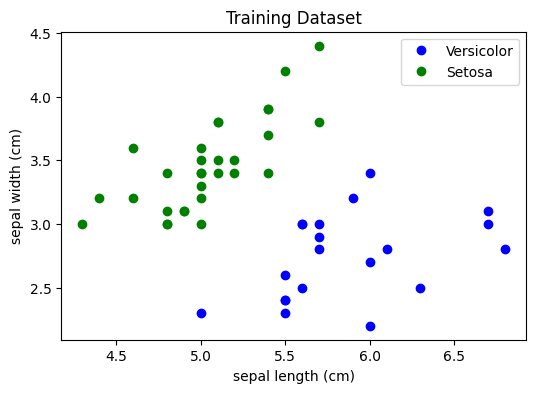

In [195]:
# Plot the samples
for x, y_target in zip(train_features, train_labels):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")

# Add a legend for the two groups
plt.plot([], [], "bo", label="Versicolor")
plt.plot([], [], "go", label="Setosa")

# Label the axis and show
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Training Dataset")

plt.legend()
plt.show()

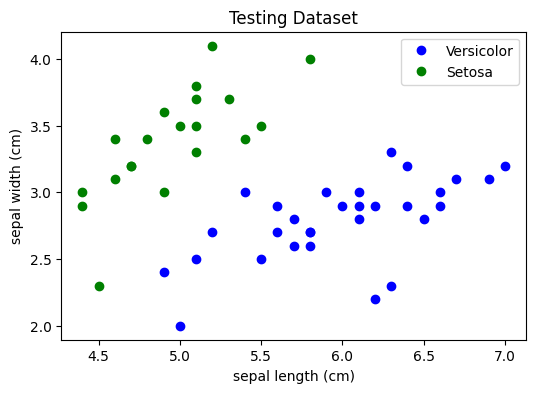

In [196]:
# Plot the samples
for x, y_target in zip(test_features, test_labels):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")

# Add a legend for the two groups
plt.plot([], [], "bo", label="Versicolor")
plt.plot([], [], "go", label="Setosa")

# Label the axis and show
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Testing Dataset")

plt.legend()
plt.show()

### Part 2.2 - Preparing the Quantum Feature Map
For this, the ZZFeatureMap class will be used. Then, a sample will be instantiated and a fidelity model can be created using the ComputeUncompute class for creating the quantum kernel:

In [197]:
# Create the feature map using the ZZFeatureMap class
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=1, entanglement="linear")

# Create and instance for the sampler with a specific number of shots
sampler = Sampler(options={'shots':10000})

# Compute the state fidelity using the ComputeUncompute class
fidelity = ComputeUncompute(sampler=sampler)

# Create an instance of the quantum kernel
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

/tmp/ipykernel_562889/1799593977.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler(options={'shots':10000})


### Part 2.3 - Computing the Kernel Matrices
Now, the two datasets can be used to obtain the desired kernel matrices:

In [198]:
# Evaluate the kernel with the datasets to compute the matrices
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

Both matrices can be visualized as follows:

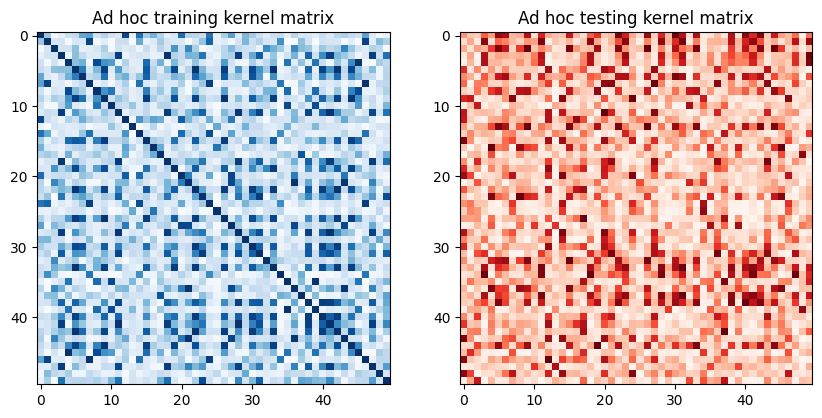

In [199]:
# Create a figure and plot the matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

### Part 2.4 - Training a Classical SVM
For this section, the SVC algorithm will be used from the Scikit-learn package. Then, the training dataset will be used to fit the model and the testing dataset can be used to get a score:

In [200]:
# Create an instance of the SVC algorithm class
adhoc_svc = SVC(kernel="precomputed")

# Train the model
adhoc_svc.fit(adhoc_matrix_train, train_labels)

# Test the model
kernel_train_score = adhoc_svc.score(adhoc_matrix_train, train_labels)
kernel_test_score = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Kernel Classifier Train Score: {kernel_train_score}")
print(f"Kernel Classifier Test Score: {kernel_test_score}")

Kernel Classifier Train Score: 1.0
Kernel Classifier Test Score: 0.98


### Part 2.5 - Testing the model
With the implementation of the classifier finished, the "predict" method can be used to test the classifier and visualize the results:

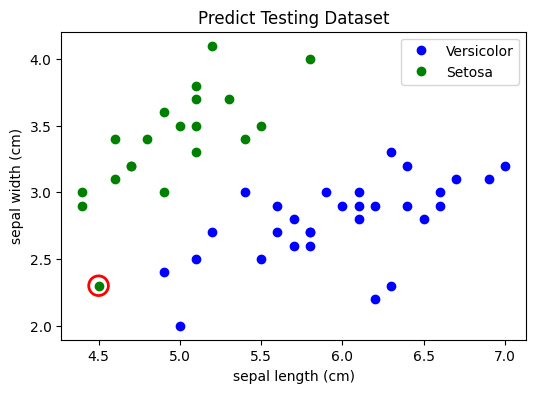

In [201]:
# Evaluate data points
y_predict = adhoc_svc.predict(adhoc_matrix_test)
y_test[y_test == -1] = 0

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, y_test, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)

# Add a legend for the two groups
plt.plot([], [], "bo", label="Versicolor")
plt.plot([], [], "go", label="Setosa")

# Label the axis
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Predict Testing Dataset")

plt.legend()
plt.show()

With a score of 0.98, the figure presents the single sample where an incorrect classification occurred.